In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error,mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



In [ ]:

# Set global font size
plt.rcParams.update({'font.size': 18})

# Load the CSV file
file_path = "simulation_results_with_pressure_without_early_values.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Remove rows where the time column is 0, 1, or 60
filtered_df = df[~df['time'].isin([0, 1])]
df = filtered_df

# Load or prepare your dataset
simulation_data = df

# Split the dataset into features (X) and target variables (y)
X = simulation_data.drop(columns=["volAverage(T)", "volAverage(Bu)", "rodPressure"])
y_temp = simulation_data["volAverage(T)"]

# Bin the continuous target into categories for stratification
num_bins = 10
y_temp_bins = pd.qcut(y_temp, q=num_bins, duplicates='drop', labels=False)

# Train-validation-test split: 80%-10%-10% with stratification
X_train, X_temp, y_train, y_temp, y_bins_train, y_bins_temp = train_test_split(
    X, y_temp, y_temp_bins, test_size=0.2, random_state=42, stratify=y_temp_bins
)

X_val, X_test, y_val, y_test, y_bins_val, y_bins_test = train_test_split(
    X_temp, y_temp, y_bins_temp, test_size=0.5, random_state=42, stratify=y_bins_temp
)

# Initialize scalers for features (X) and target (y)
scaler_X = StandardScaler()

# Scale the features (X)
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Convert scaled X and y back to pandas DataFrame and Series
X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns, index=X_val.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_rmse, val_rmse = [], []
    train_mae, val_mae = [], []
    train_r2, val_r2 = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None

    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        model = model_class(**fold_best_params)
        model.fit(X_t, y_t)

        # Evaluate training and validation performance on the fold
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)

        # Calculate metrics
        train_rmse.append(mean_squared_error(y_t, y_t_pred, squared=False))
        val_rmse.append(mean_squared_error(y_v, y_v_pred, squared=False))
        train_mae.append(mean_absolute_error(y_t, y_t_pred))
        val_mae.append(mean_absolute_error(y_v, y_v_pred))
        train_r2.append(r2_score(y_t, y_t_pred))
        val_r2.append(r2_score(y_v, y_v_pred))

        # Keep track of the best model across folds based on validation loss
        if val_rmse[-1] < best_rmse:
            best_rmse = val_rmse[-1]
            best_model = model
            best_params = fold_best_params

    return {
        "model": best_model,
        "train_rmse": train_rmse,
        "val_rmse": val_rmse,
        "train_mae": train_mae,
        "val_mae": val_mae,
        "train_r2": train_r2,
        "val_r2": val_r2,
        "best_params": best_params
    }


# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}

# Train models
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train)
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train)

# Combine results
results_summary = {
    "Model": ["LightGBM", "XGBoost"],
    "RMSE (mean ± std)": [
        f"{np.mean(lgb_results['val_rmse']):.4f} ± {np.std(lgb_results['val_rmse']):.4f}",
        f"{np.mean(xgb_results['val_rmse']):.4f} ± {np.std(xgb_results['val_rmse']):.4f}"
    ],
    "MAE (mean ± std)": [
        f"{np.mean(lgb_results['val_mae']):.4f} ± {np.std(lgb_results['val_mae']):.4f}",
        f"{np.mean(xgb_results['val_mae']):.4f} ± {np.std(xgb_results['val_mae']):.4f}"
    ],
    "R² (mean ± std)": [
        f"{np.mean(lgb_results['val_r2']):.4f} ± {np.std(lgb_results['val_r2']):.4f}",
        f"{np.mean(xgb_results['val_r2']):.4f} ± {np.std(xgb_results['val_r2']):.4f}"
    ]
}

# Display results
results_df = pd.DataFrame(results_summary)
print("Cross-Validation Results Summary:")
print(results_df)

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": mean_squared_error(y_test, lgb_test_pred, squared=False),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": mean_squared_error(y_test, xgb_test_pred, squared=False),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display final test results
test_results_df = pd.DataFrame(test_results).T
print("\nFinal Test Results:")
print(test_results_df)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1079.240443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1079.240443


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1078.639464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1518
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1078.639464


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1078.931459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 71398, number of used features: 6
[LightGBM] [Info] Start training from score 1078.931459


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 71399, number of used features: 6
[LightGBM] [Info] Start training from score 1079.449496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 71399, number of used features: 6
[LightGBM] [Info] Start training from score 1079.449496


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 71399, number of used features: 6
[LightGBM] [Info] Start training from score 1079.703434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 71399, number of used features: 6
[LightGBM] [Info] Start training from score 1079.703434


c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\iltergo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

In [3]:
# Extract and display the best hyperparameters for LightGBM and XGBoost
print("Best Hyperparameters:")
print(f"LightGBM: {lgb_results['best_params']}")
print(f"XGBoost: {xgb_results['best_params']}")


Best Hyperparameters:
LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 40}
XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


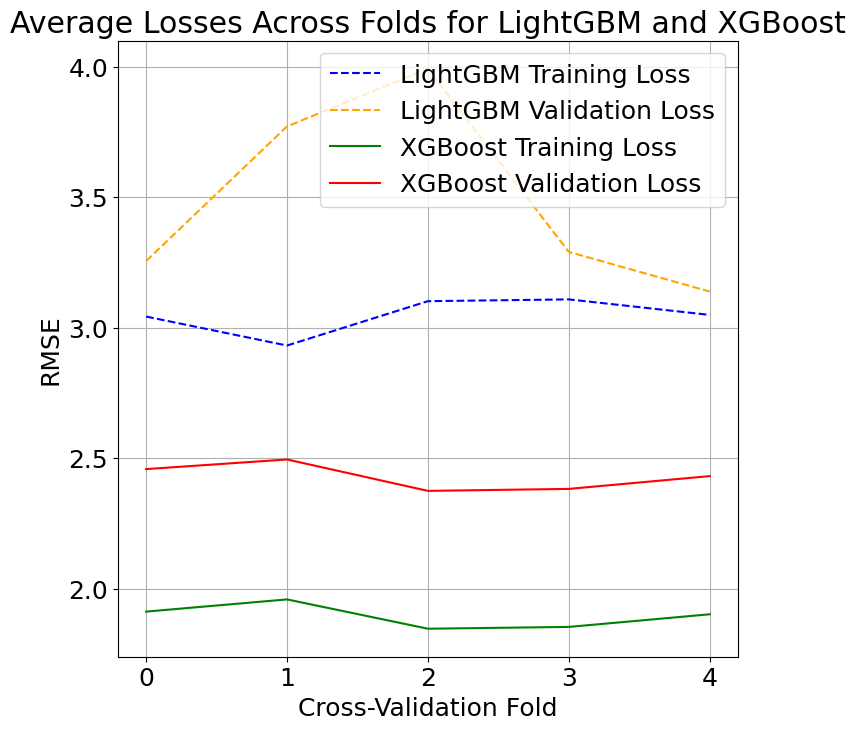

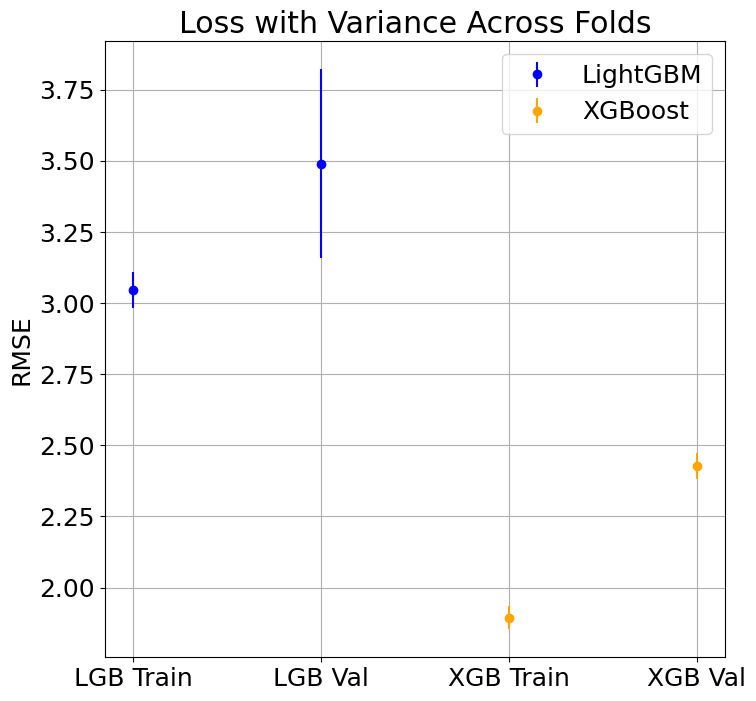

In [4]:
# Plot Average Losses Across Folds
plt.figure(figsize=(8, 8))
plt.plot(lgb_results["train_rmse"], label="LightGBM Training Loss", linestyle="--", color="blue")
plt.plot(lgb_results["val_rmse"], label="LightGBM Validation Loss", linestyle="--", color="orange")
plt.plot(xgb_results["train_rmse"], label="XGBoost Training Loss", linestyle="-", color="green")
plt.plot(xgb_results["val_rmse"], label="XGBoost Validation Loss", linestyle="-", color="red")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_rmse"])
std_train_loss_lgb = np.std(lgb_results["train_rmse"])
mean_val_loss_lgb = np.mean(lgb_results["val_rmse"])
std_val_loss_lgb = np.std(lgb_results["val_rmse"])

mean_train_loss_xgb = np.mean(xgb_results["train_rmse"])
std_train_loss_xgb = np.std(xgb_results["train_rmse"])
mean_val_loss_xgb = np.mean(xgb_results["val_rmse"])
std_val_loss_xgb = np.std(xgb_results["val_rmse"])

plt.figure(figsize=(8, 8))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM", color="blue")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost", color="orange")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 89248, number of used features: 6
[LightGBM] [Info] Start training from score 1079.192861


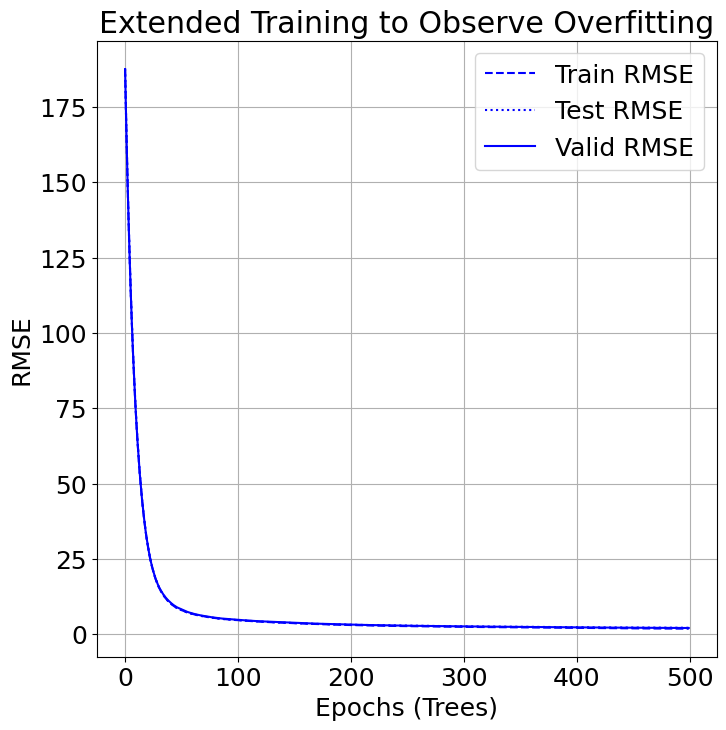

In [5]:
# Suppose after tuning, you have:
best_params = lgb_results["best_params"]  # For LightGBM as an example

# Let's say we want to train for 500 trees to observe overfitting behavior
long_run_params = best_params.copy()
long_run_params["n_estimators"] = 500  # Increase number of trees
# Remove or do not use early_stopping callback

model = lgb.LGBMRegressor(**long_run_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test), (X_val, y_val)],
    eval_names=["train", "test", "valid"],
    eval_metric="rmse",
    # No early stopping callback here
)

# Retrieve results
evals_result_long = model.evals_result_

# Plot the curves
plt.figure(figsize=(8, 8))
plt.plot(evals_result_long["train"]["rmse"], label="Train RMSE", linestyle='--', color='blue')
plt.plot(evals_result_long["test"]["rmse"], label="Test RMSE", linestyle=':', color='blue')
plt.plot(evals_result_long["valid"]["rmse"], label="Valid RMSE", linestyle='-', color='blue')
plt.xlabel("Epochs (Trees)")
plt.ylabel("RMSE")
plt.title("Extended Training to Observe Overfitting")
plt.legend()
plt.grid()
plt.show()


RMSE for LightGBM (Unscaled): 3.1767
RMSE for XGBoost (Unscaled): 2.3872
Real Temperature Predictions (Unscaled):
      Actual  LGBM Prediction  XGBoost Prediction
0  1009.1180      1011.508463         1010.257812
1   924.2286       921.480618          923.594910
2  1132.9700      1126.569857         1131.907104
3   936.4719       940.192558          937.151611
4  1320.0080      1324.489151         1322.286621


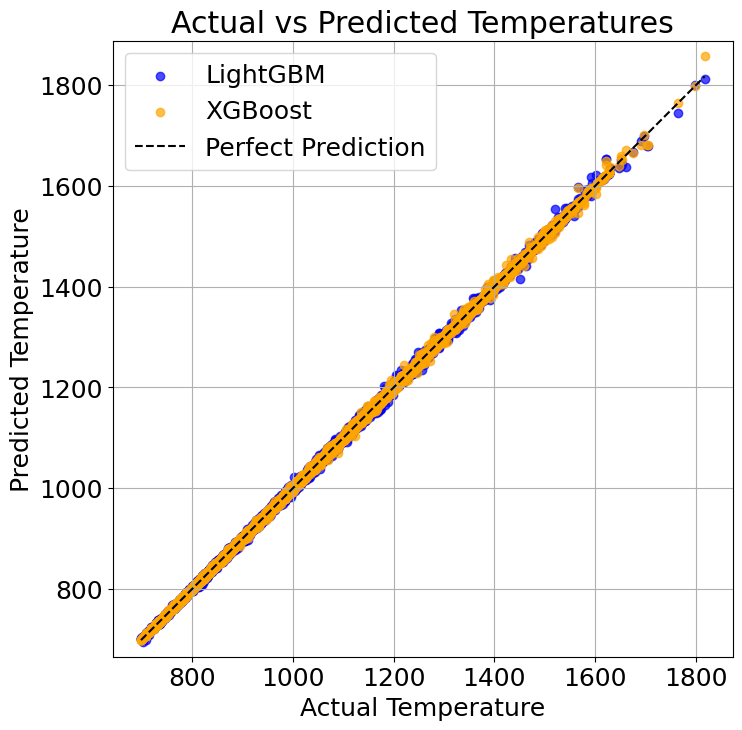

In [6]:
# Combine actual and predicted values into a DataFrame for easier visualization
results_df = pd.DataFrame({
    "Actual": y_test.to_numpy(),  # Actual values (unscaled)
    "LGBM Prediction": lgb_test_pred,  # LightGBM predictions
    "XGBoost Prediction": xgb_test_pred  # XGBoost predictions
})

# Calculate RMSE for LightGBM and XGBoost predictions
rmse_lgb_real = root_mean_squared_error(y_test.to_numpy(), lgb_test_pred)
rmse_xgb_real = root_mean_squared_error(y_test.to_numpy(), xgb_test_pred)

# Print the RMSE results
print(f"RMSE for LightGBM (Unscaled): {rmse_lgb_real:.4f}")
print(f"RMSE for XGBoost (Unscaled): {rmse_xgb_real:.4f}")

# Print the results DataFrame for verification
print("Real Temperature Predictions (Unscaled):")
print(results_df.head())

# Plot to compare actual and predicted values
plt.figure(figsize=(8, 8))

# Scatter plot for actual vs LightGBM predictions
plt.scatter(y_test, lgb_test_pred, label="LightGBM", alpha=0.7, color="blue")
# Scatter plot for actual vs XGBoost predictions
plt.scatter(y_test, xgb_test_pred, label="XGBoost", alpha=0.7, color="orange")

# Add a reference line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         label="Perfect Prediction", linestyle="--", color="black")

# Set axis limits and make axes equal
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.axis("equal")  # Ensures equal scaling

plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted Temperatures")
plt.legend()
plt.grid()
plt.show()





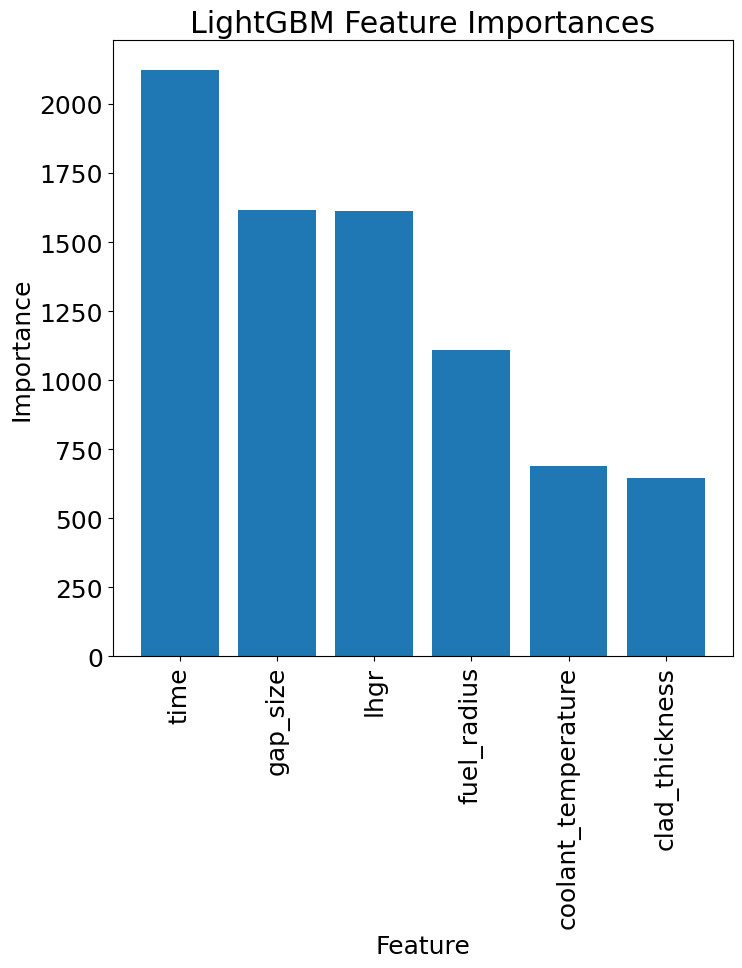

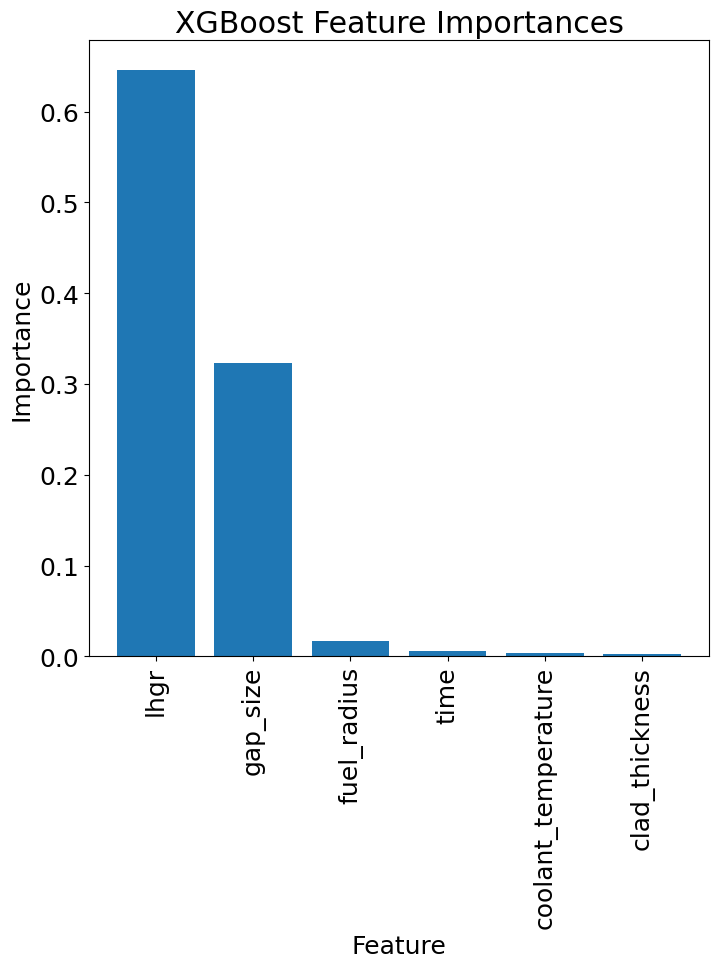

In [7]:
def plot_feature_importance(model, feature_names, model_name):
    """
    Plot feature importance for a given model.
    """
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        sorted_indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 8))
        plt.bar(range(len(importances)), importances[sorted_indices], align="center")
        plt.xticks(range(len(importances)), [feature_names[i] for i in sorted_indices], rotation=90)
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.title(f"{model_name} Feature Importances")
        plt.show()
    else:
        print(f"The model '{model_name}' does not have feature_importances_ attribute.")

# Example: Plot feature importances for the best LightGBM model
plot_feature_importance(lgb_results["model"], X_train.columns, "LightGBM")
plot_feature_importance(xgb_results["model"], X_train.columns, "XGBoost")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 11157, number of used features: 6
[LightGBM] [Info] Start training from score 1079.696036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 11157, number of used features: 6
[LightGBM] [Info] Start training from score 1079.738735
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 11157, number of used features: 6
[LightGBM] [Info] Start 

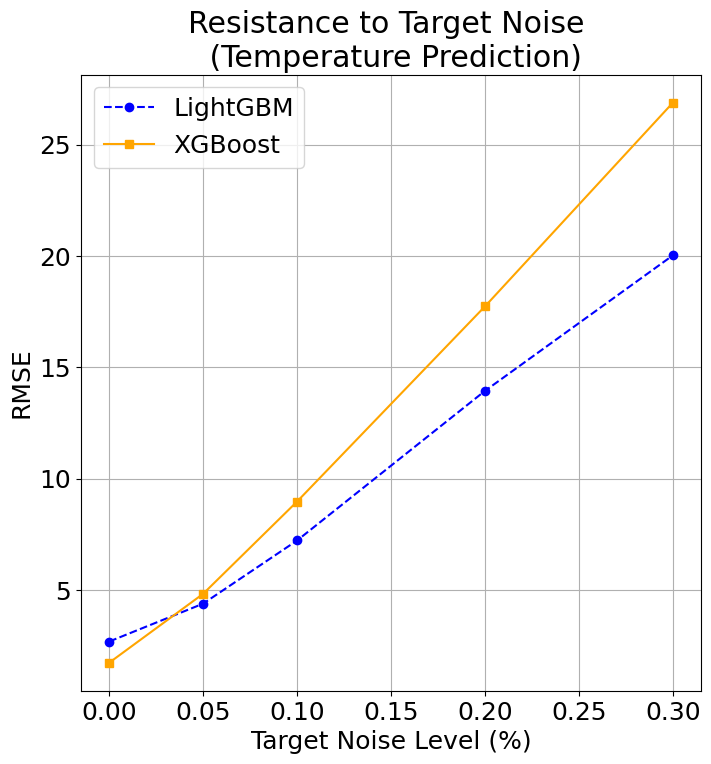

<Figure size 640x480 with 0 Axes>

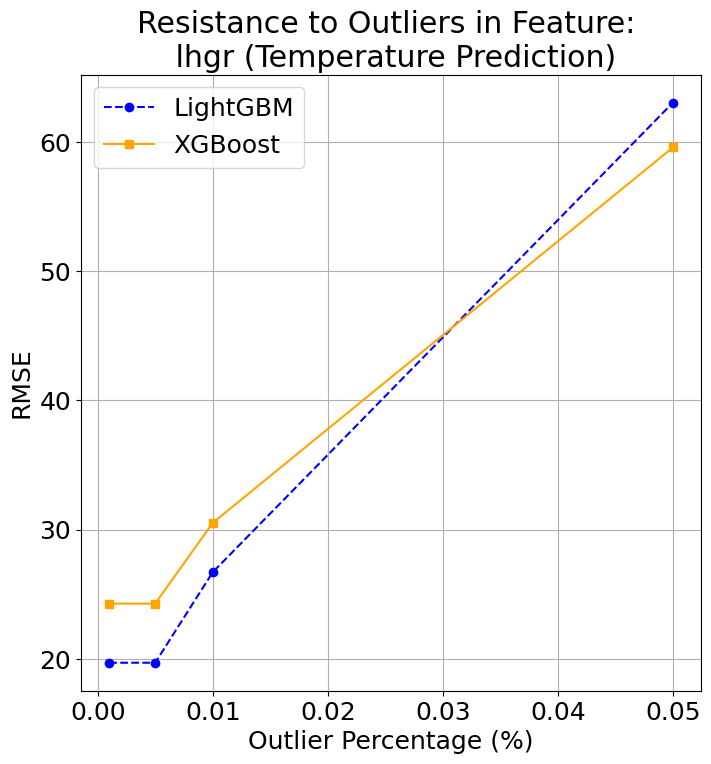

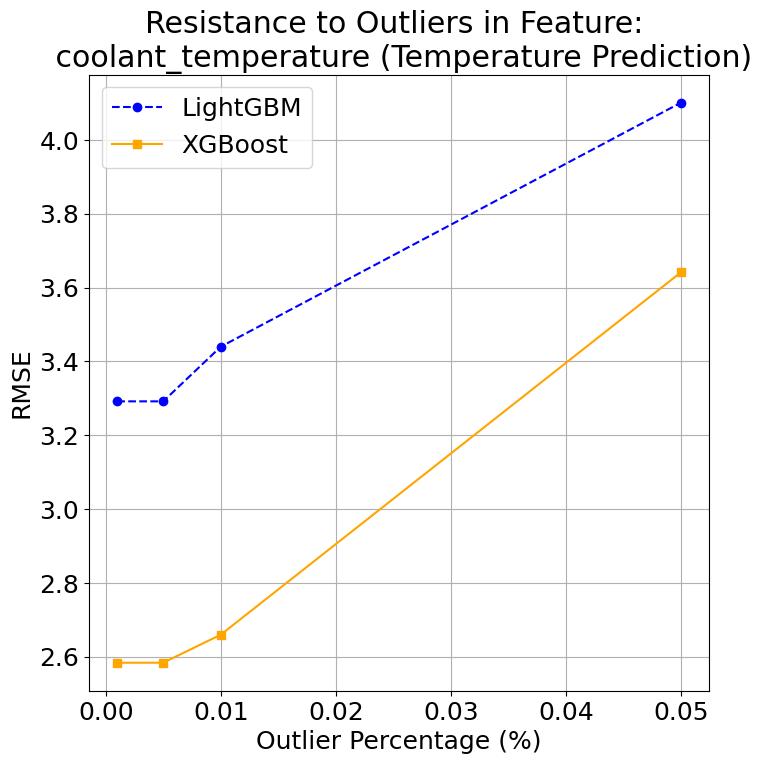

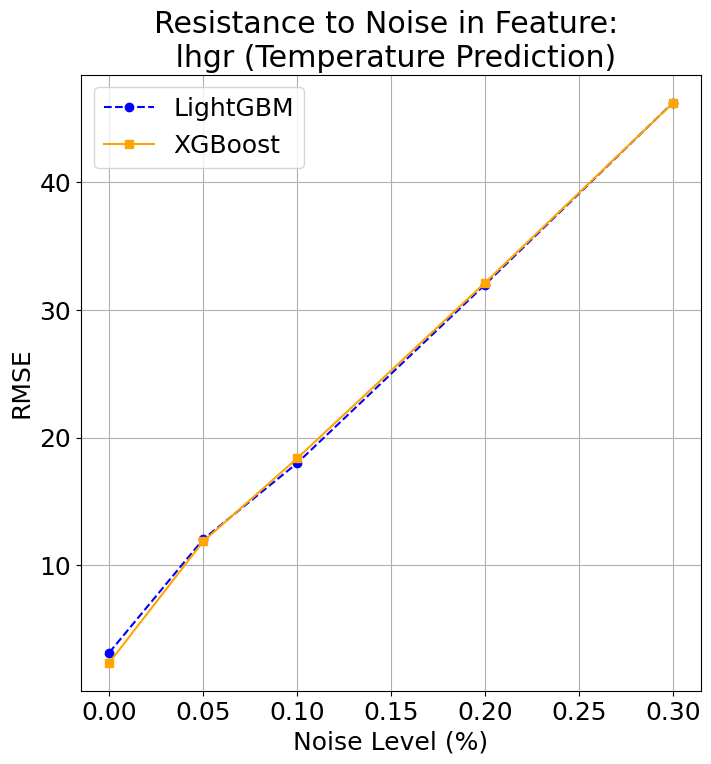

<Figure size 640x480 with 0 Axes>

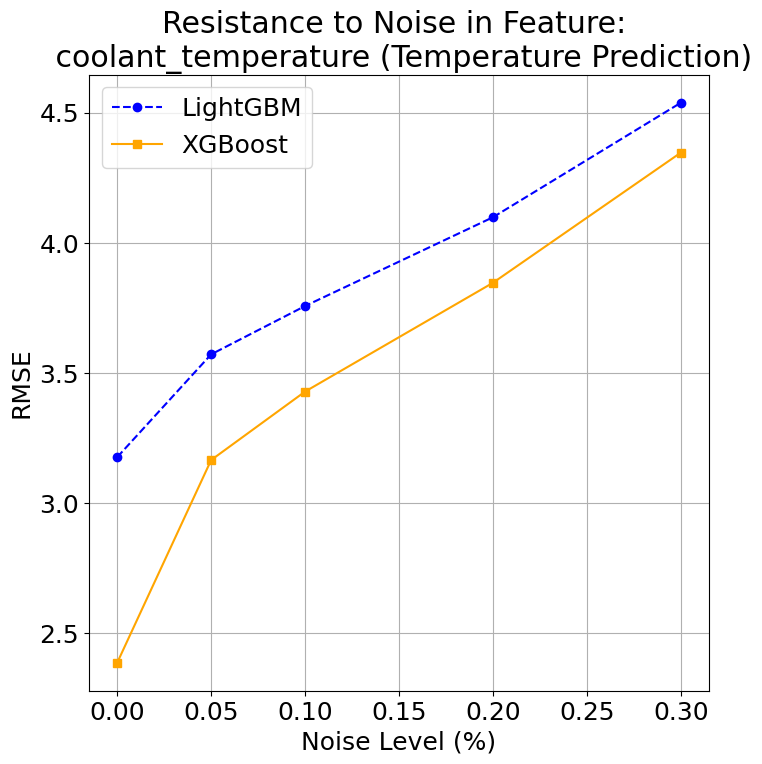

<Figure size 640x480 with 0 Axes>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def add_gaussian_noise(data, column, noise_level=0.1):
    """
    Add Gaussian noise to a specified column and reset index.
    """
    noisy_data = data.copy()
    std_dev = noisy_data[column].std() * noise_level
    noise = np.random.normal(0, std_dev, size=noisy_data[column].shape)
    noisy_data[column] += noise
    return noisy_data.reset_index(drop=True)


def add_outliers(data, column, num_outliers=10, scale=10):
    """
    Add outliers to a specified column and reset index.
    """
    outlier_data = data.copy().reset_index(drop=True)
    for _ in range(num_outliers):
        row_idx = np.random.randint(0, len(outlier_data))
        outlier_data.loc[row_idx, column] += scale * outlier_data[column].std()
    return outlier_data

def calculate_rmse(y_true, y_pred):
    """
    Calculate RMSE between true and predicted values.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

import copy
def noise_resistance_experiment(X, y, model, feature_noise_cols, noise_levels, outlier_levels=None, target_noise=False, outliers=False):
    """
    Evaluate model's resistance to multiple levels of noise, outliers, and target noise.
    Compute RMSE directly without inverse transformations (since y is in original scale).
    """
    results = {}

    # Baseline prediction
    baseline_preds = model.predict(X)
    baseline_rmse = np.sqrt(mean_squared_error(y, baseline_preds))
    results["Baseline RMSE"] = baseline_rmse

    # Feature noise at multiple levels
    for noise_level in noise_levels:
        for col in feature_noise_cols:
            noisy_X = add_gaussian_noise(X, column=col, noise_level=noise_level)
            noisy_preds = model.predict(noisy_X)
            noisy_rmse = np.sqrt(mean_squared_error(y, noisy_preds))
            results[f"Noise on {col} ({noise_level * 100:.0f}%)"] = noisy_rmse

    # Target noise
    if target_noise:
        for noise_level in noise_levels:
            noisy_y = y.copy() + np.random.normal(0, noise_level * y.std(), y.shape)

            # Create a copy of the model for retraining
            temp_model = copy.deepcopy(model)

            # Retrain model with target noise
            if isinstance(temp_model, xgb.XGBRegressor):
                temp_model.fit(X, noisy_y, eval_set=[(X, noisy_y)], verbose=False)
            else:
                temp_model.fit(X, noisy_y)

            noisy_target_preds = temp_model.predict(X)
            noisy_rmse = np.sqrt(mean_squared_error(y, noisy_target_preds))
            results[f"Target Noise ({noise_level * 100:.0f}%)"] = noisy_rmse

    # Outliers at multiple levels
    if outliers:
        for level in outlier_levels:
            for col in feature_noise_cols:
                num_outliers = int(level * len(X))
                outlier_X = add_outliers(X, column=col, num_outliers=num_outliers, scale=10)
                outlier_preds = model.predict(outlier_X)
                outlier_rmse = np.sqrt(mean_squared_error(y, outlier_preds))
                results[f"Outliers in {col} ({level * 100:.0f}%)"] = outlier_rmse

    return results



# Visualization Function for Noise Levels
def compare_noise_levels(lgb_results, xgb_results, noise_levels, feature_noise_cols, experiment_title):
    """
    Compare and visualize RMSE for different noise levels for LightGBM and XGBoost.
    """
    for col in feature_noise_cols:
        lgb_values = [lgb_results[f"Noise on {col} ({noise_level * 100:.0f}%)"] for noise_level in noise_levels]
        xgb_values = [xgb_results[f"Noise on {col} ({noise_level * 100:.0f}%)"] for noise_level in noise_levels]

        # Plot
        fig = plt.figure(figsize=(8, 8))
        plt.plot(noise_levels, lgb_values, label="LightGBM", marker='o', linestyle='--', color='blue')
        plt.plot(noise_levels, xgb_values, label="XGBoost", marker='s', linestyle='-', color='orange')

        plt.xlabel("Noise Level (%)")
        plt.ylabel("RMSE")
        plt.title(f"Resistance to Noise in Feature: \n {col} ({experiment_title})")
        plt.legend()
        plt.grid()
        plt.show()
        
        plt.savefig('noise_levels.pdf', format='pdf')   

# Visualization Function for Target Noise Levels
def compare_target_noise_levels(lgb_results, xgb_results, noise_levels, experiment_title):
    """
    Compare and visualize RMSE for different levels of target noise for LightGBM and XGBoost.
    """
    lgb_values = [lgb_results[f"Target Noise ({noise_level * 100:.0f}%)"] for noise_level in noise_levels]
    xgb_values = [xgb_results[f"Target Noise ({noise_level * 100:.0f}%)"] for noise_level in noise_levels]

    fig = plt.figure(figsize=(8, 8))
    plt.plot(noise_levels, lgb_values, label="LightGBM", marker='o', linestyle='--', color='blue')
    plt.plot(noise_levels, xgb_values, label="XGBoost", marker='s', linestyle='-', color='orange')

    plt.xlabel("Target Noise Level (%)")
    plt.ylabel("RMSE")
    plt.title(f"Resistance to Target Noise \n ({experiment_title})")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.savefig('target_noise_levels.pdf', format='pdf')


# Visualization Function for Outlier Percentages
def compare_outlier_impact(lgb_results, xgb_results, outlier_levels, feature_noise_cols, experiment_title):
    """
    Compare and visualize RMSE for different percentages of outliers in selected features for LightGBM and XGBoost.
    """
    for col in feature_noise_cols:
        lgb_values = [lgb_results[f"Outliers in {col} ({level * 100:.0f}%)"] for level in outlier_levels]
        xgb_values = [xgb_results[f"Outliers in {col} ({level * 100:.0f}%)"] for level in outlier_levels]

        # Plot
        plt.figure(figsize=(8, 8))
        plt.plot(outlier_levels, lgb_values, label="LightGBM", marker='o', linestyle='--', color='blue')
        plt.plot(outlier_levels, xgb_values, label="XGBoost", marker='s', linestyle='-', color='orange')

        plt.xlabel("Outlier Percentage (%)")
        plt.ylabel("RMSE")
        plt.title(f"Resistance to Outliers in Feature: \n {col} ({experiment_title})")
        plt.legend()
        plt.grid()
        plt.show()


# Define noise levels and outlier levels
noise_levels = [0, 0.05, 0.1, 0.2, 0.3]  # Noise levels for feature and target
outlier_levels = [0.001, 0.005, 0.01, 0.05]  # Percentages of outliers

feature_noise_columns = ["lhgr", "coolant_temperature"]  # Adjust to your dataset's column names


# Run noise resistance experiments for LightGBM
lgb_resistance_results = noise_resistance_experiment(
    X_test, y_test, lgb_results["model"], feature_noise_cols=feature_noise_columns, 
     noise_levels=noise_levels, outlier_levels=outlier_levels, target_noise=True, outliers=True
)

# Run noise resistance experiments for XGBoost
xgb_resistance_results = noise_resistance_experiment(
    X_test, y_test, xgb_results["model"], feature_noise_cols=feature_noise_columns, 
     noise_levels=noise_levels, outlier_levels=outlier_levels, target_noise=True, outliers=True
)

# Compare and visualize results for different noise levels in target
compare_target_noise_levels(
    lgb_resistance_results, xgb_resistance_results, 
    noise_levels=noise_levels, experiment_title="Temperature Prediction"
)

# Compare and visualize results for different percentages of outliers in selected features
compare_outlier_impact(
    lgb_resistance_results, xgb_resistance_results, 
    outlier_levels=outlier_levels, feature_noise_cols=feature_noise_columns, 
    experiment_title="Temperature Prediction"
)
# Compare and visualize results for different noise levels
compare_noise_levels(
    lgb_resistance_results, xgb_resistance_results, 
    noise_levels=noise_levels, feature_noise_cols=feature_noise_columns, 
    experiment_title="Temperature Prediction"
)


In [ ]:
# def dilute_time_samples(data, time_col, dilution_factor):
#     """
#     Dilutes the dataset by randomly removing a fraction of time samples for each unique feature combination.

#     Parameters:
#         data (pd.DataFrame): Input dataset.
#         time_col (str): The column name representing time.
#         dilution_factor (float): Fraction of time samples to remove (0 <= dilution_factor < 1).

#     Returns:
#         pd.DataFrame: Diluted dataset.
#     """
#     diluted_data = []

#     # Group by feature combinations excluding the time column
#     feature_groups = data.groupby(data.columns.difference([time_col]).tolist())

#     for _, group in feature_groups:
#         n_samples = len(group)
#         n_to_keep = max(1, int((1 - dilution_factor) * n_samples))
#         diluted_group = group.sample(n=n_to_keep, random_state=42)
#         diluted_data.append(diluted_group)

#     return pd.concat(diluted_data, ignore_index=True)

# def evaluate_dilution_impact(dilution_factors, model_name, model_class, param_grid, X_train, X_val, X_test, y_train, y_val, y_test, time_col):
#     """
#     Evaluate the impact of dilution on model performance.

#     Parameters:
#         dilution_factors (list): List of dilution factors to evaluate.
#         model_name (str): Name of the model (e.g., 'LightGBM').
#         model_class: Model class (e.g., lgb.LGBMRegressor).
#         param_grid (dict): Hyperparameter grid for tuning.
#         X_train, X_val, X_test (pd.DataFrame): Features.
#         y_train, y_val, y_test (pd.Series): Target variables.
#         time_col (str): The column name representing time.

#     Returns:
#         dict: RMSE values for each dilution factor.
#     """
#     results = {}

#     for factor in dilution_factors:
#         # Combine train, validation, and test data for dilution
#         combined_X = pd.concat([X_train, X_val, X_test], axis=0)
#         combined_y = pd.concat([y_train, y_val, y_test], axis=0)
#         combined_data = pd.concat([combined_X, combined_y], axis=1)

#         # Dilute dataset
#         diluted_data = dilute_time_samples(combined_data, time_col, factor)
#         X_diluted = diluted_data[X_train.columns]
#         y_diluted = diluted_data[combined_y.name]

#         # Split back into train, validation, and test sets
#         X_train_diluted, X_temp, y_train_diluted, y_temp = train_test_split(
#             X_diluted, y_diluted, test_size=0.4, random_state=42
#         )
#         X_val_diluted, X_test_diluted, y_val_diluted, y_test_diluted = train_test_split(
#             X_temp, y_temp, test_size=0.5, random_state=42
#         )

#         # Train and evaluate model
#         kf = KFold(n_splits=5, shuffle=True, random_state=42)
#         best_rmse = float("inf")

#         for train_index, val_index in kf.split(X_train_diluted):
#             X_t, X_v = X_train_diluted.iloc[train_index], X_train_diluted.iloc[val_index]
#             y_t, y_v = y_train_diluted.iloc[train_index], y_train_diluted.iloc[val_index]

#             grid_search = GridSearchCV(
#                 estimator=model_class(),
#                 param_grid=param_grid,
#                 scoring='neg_root_mean_squared_error',
#                 cv=3,
#                 verbose=0,
#                 n_jobs=-1
#             )
#             grid_search.fit(X_t, y_t)
#             best_params = grid_search.best_params_

#             model = model_class(**best_params)
#             model.fit(X_t, y_t)
#             y_v_pred = model.predict(X_v)
#             rmse = root_mean_squared_error(y_v, y_v_pred)

#             best_rmse = min(best_rmse, rmse)

#         results[factor] = best_rmse

#     return results

# # Specify dilution factors to test
# dilution_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,0.8, 0.9,0.95]  # 0.0 means no dilution

# time_col = 'time'

# # Evaluate LightGBM model
# lgb_param_grid = {
#     "num_leaves": [20, 31, 40],
#     "learning_rate": [0.1, 0.05, 0.01],
#     "n_estimators": [50, 100, 200]
# }
# lgb_results = evaluate_dilution_impact(
#     dilution_factors, "LightGBM", lgb.LGBMRegressor, lgb_param_grid,
#     X_train, X_val, X_test, y_train, y_val, y_test, time_col
# )

# # Evaluate XGBoost model
# xgb_param_grid = {
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.1, 0.05, 0.01],
#     "n_estimators": [50, 100, 200]
# }
# xgb_results = evaluate_dilution_impact(
#     dilution_factors, "XGBoost", xgb.XGBRegressor, xgb_param_grid,
#     X_train, X_val, X_test, y_train, y_val, y_test, time_col
# )

# # Plot RMSE vs Dilution Factor
# plt.figure(figsize=(8, 8))
# plt.plot(dilution_factors, list(lgb_results.values()), label="LightGBM", marker='o')
# plt.plot(dilution_factors, list(xgb_results.values()), label="XGBoost", marker='o')
# plt.xlabel("Dilution Factor")
# plt.ylabel("RMSE")
# plt.title("RMSE vs Dilution Factor")
# plt.legend()
# plt.grid()
# plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 53548, number of used features: 6
[LightGBM] [Info] Start training from score 1078.372469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 53548, number of used features: 6
[LightGBM] [Info] Start training from score 1078.372469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 53549, number of used features: 6
[LightGBM] [Info] Start 